<a href="https://colab.research.google.com/github/BrendoAires/BrendoAires/blob/main/Case%20Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objetivo:
###Prever clientes com maiores chances de acancelar o serviço.



##Entendendo os dados:

####Numéricas:

```
#Tenuring: Número de meses que o cliente está na base
#MonthlyCharges: Valor consumido pelo cliente mensalmente
#TotalCharges: Valor total consumido pelo cliente
```


###Categóricas:

```
#ID do cliente
#Gênero (Masculino, Feminino)
#Idoso (Sim, Não)
#Casado (Sim, Não)
#Dependentes (Sim, Não)
#Serviço de telefone (Sim, Não)
#Múltiplas linhas de telefone (Sim, Não)
#Tipo de serviço de internet
#Segurança online (Sim, Não)
#Backup online (Sim, Não)
#Proteção de dispositivos (Sim, Não)
#Suporte técnico (Sim, Não)
#Streaming de TV (Sim, Não)
#Streaming de filmes (Sim, Não)
#Contrato (Mensal, Anual)
#Fatura por papel (Sim, Não)
#Pagamento eletrônico (Sim, Não)
#Método de pagamento (Cartão de crédito, Débito, Boleto, Transferência)
```



###Importando bibliotecas


In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3144b4f56a2644c411e49ba708d4769b04651061210b51028d22cb77413a2612
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay

from imblearn.over_sampling import SMOTE

import random
from lime import lime_tabular

from xgboost import XGBClassifier


###Carregando datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data = '/content/drive/My Drive/Colab Notebooks/churn_data.xlsx'
df = pd.read_excel(data)

Mounted at /content/drive


###Lendo as primeiras linhas do dataset

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


###Verificando se há valores nulos

In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

###Verificando variáveis quantitativas

In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
df.isna().count()

customerID          7032
gender              7032
SeniorCitizen       7032
Partner             7032
Dependents          7032
tenure              7032
PhoneService        7032
MultipleLines       7032
InternetService     7032
OnlineSecurity      7032
OnlineBackup        7032
DeviceProtection    7032
TechSupport         7032
StreamingTV         7032
StreamingMovies     7032
Contract            7032
PaperlessBilling    7032
PaymentMethod       7032
MonthlyCharges      7032
TotalCharges        7032
Churn               7032
dtype: int64

In [8]:

churn_agg = df.groupby('Churn')['customerID'].count().reset_index()
churn_agg

,Churn,customerID
0,No,5163
1,Yes,1869


###Verificando tipos de dados

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


###Dropna nas colunas por segurança

In [10]:
df=df.dropna()

#Análise Exploratória
```
Gráfico de barras

-Clientes Churn
-Clientes Não Churn
```


```
Gráfico de barras

-Contagem de clientes por forma de pagamento
```


```
Gráfico de barras

-Contagem por gênero
```


In [11]:
#Contagem de churns
cont_churn = df['Churn'].value_counts()
print(cont_churn)

Churn
No     5163
Yes    1869
Name: count, dtype: int64


In [12]:
#Contagem por método de pagamento
metodo_pagamento = df['PaymentMethod'].value_counts()
print(metodo_pagamento)

PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64


In [13]:
#Contagem de clientes por gênero
cont_genero = df['gender'].value_counts()
print(cont_genero)

gender
Male      3549
Female    3483
Name: count, dtype: int64


[]

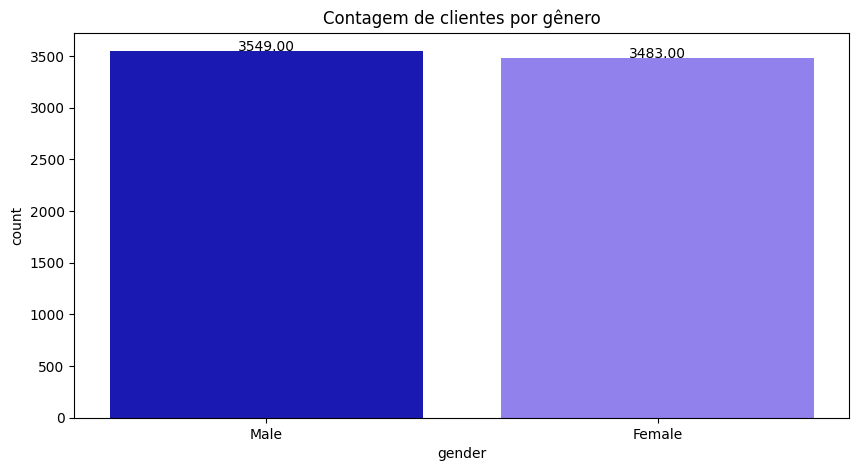

In [14]:
df_genero = pd.DataFrame(cont_genero)

colors = ["#0000CD", '#836FFF']
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(10,5))


ax=sns.barplot(x='gender', y=cont_genero, hue='gender', data=df_genero)

ax.set_title('Contagem de clientes por gênero')

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/2,
  height + 3,
  '{:1.2f}'.format((height)),
  ha='center')

ax.plot()

[]

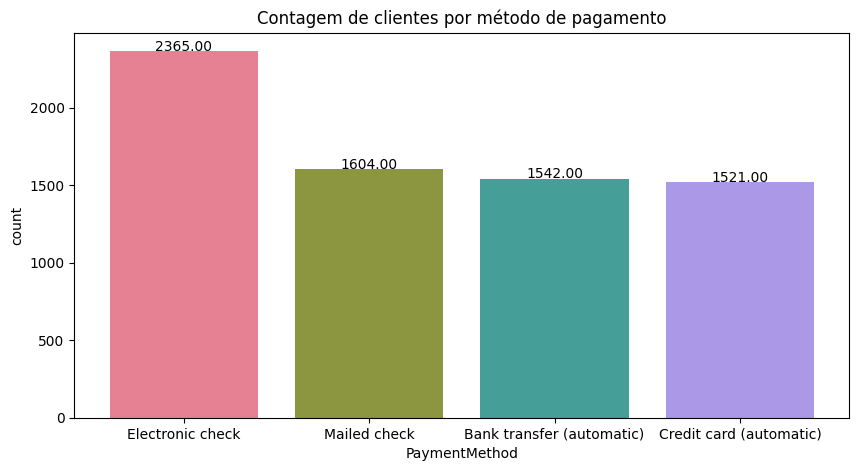

In [15]:
df_metodo = pd.DataFrame(metodo_pagamento)

colors = ["#0000CD", '#836FFF']

sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(10,5))

ax=sns.barplot(x='PaymentMethod', y=metodo_pagamento, data=df_metodo, hue='PaymentMethod')

ax.set_title("Contagem de clientes por método de pagamento")

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/2,
  height + 3,
  '{:1.2f}'.format((height)),
  ha='center')

ax.plot()


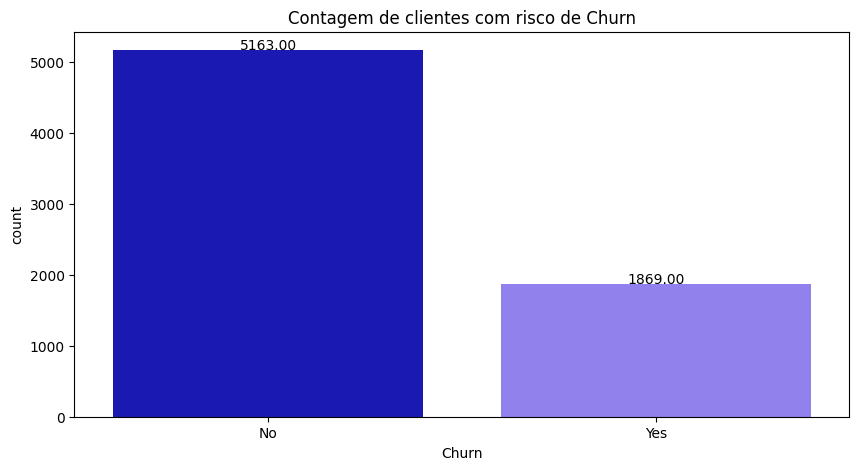

In [16]:
df_churn = pd.DataFrame(cont_churn)

colors = ["#0000CD", '#836FFF']
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(10,5))

ax=sns.barplot(x='Churn', y=cont_churn, hue='Churn', data=df_churn)

ax.set_title('Contagem de clientes com risco de Churn')

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/2,
  height + 3,
  '{:1.2f}'.format((height)),
  ha='center')

##Tratamento de variáveis categóricas

In [17]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

#Preparando os dados

In [18]:
#Drop na coluna customerID
df = df.drop(['customerID'],axis=1)

In [19]:
#Separando variáveis preditoras e target
X = df.drop(['Churn'], axis=1)
y = df['Churn'].copy()
y = pd.DataFrame(y)

In [20]:
y.value_counts()

Churn
No       5163
Yes      1869
Name: count, dtype: int64

In [21]:
#Transformando variável categóricas em variáveis numéricas
le = LabelEncoder()

le.fit(y.Churn)
y['Churn'] = le.transform(y.Churn)


X = pd.get_dummies(X)


In [22]:
#sm = SMOTE(random_state=42)
#X, y = sm.fit_resample(X,y)

In [23]:
#Normalizando colunas numéricas
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
X = pd.DataFrame(mm.fit_transform(X))

#Separando dataset em treino e test

In [24]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25)


#Logistic Regression

In [25]:
model = LogisticRegression()
lr = model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
lr.predict(X_test)

array([0, 1, 0, ..., 0, 1, 1])

In [27]:
X_test.assign(churn=y_test).assign(label = lr.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,churn,label
5839,0.0,1.000000,0.852736,0.865324,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
2098,1.0,0.140845,0.516915,0.094150,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
3762,0.0,0.760563,0.592040,0.490145,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0
1819,0.0,1.000000,0.020398,0.159514,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
60,0.0,0.647887,0.818408,0.540999,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,1.0,0.690141,0.900498,0.624637,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
5729,0.0,0.000000,0.023383,0.000208,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0
4744,0.0,0.309859,0.021891,0.053346,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0
4890,0.0,0.028169,0.069652,0.004627,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1


In [28]:
explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', class_names=y, feature_names = X_train.columns.values.tolist(), verbose=True)
explainer

In [29]:
idx = random.randint(1, len(X_test))

In [30]:
explanation = explainer.explain_instance(X_test.values[idx], lr.predict_proba, num_features=len(X_train.columns.values))

explanation.show_in_notebook(show_table=True)


Intercept 0.07333725291896676
Prediction_local [0.29949154]
Right: 0.3349711794510289


##Métricas

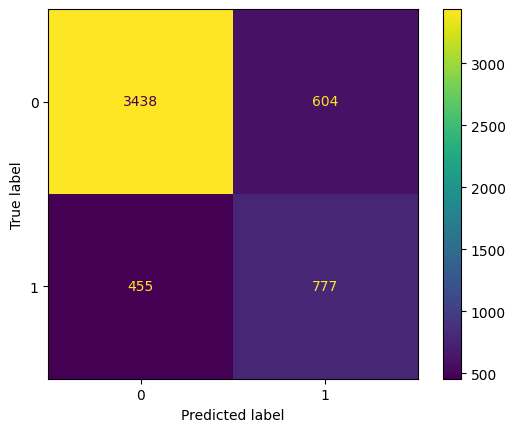

In [31]:
#Matriz de Confusão

cm = confusion_matrix(lr.predict(X_test), y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm )
disp.plot()


Acurácia Treino: 80.26%
Acurácia Teste: 79.92%
Acurácia Balanceada Treino: 73.15%
Acurácia Balanceada Teste: 72.29%
Precisão Treino: 66.91%
Precisão Teste: 63.07%
Recall Treino: 57.17%
Recall Teste: 56.26%
f1-score Treino: 61.66%
f1-score Teste: 59.47%
ROCAUC Treino: 84.66%
ROCAUC Teste: 84.25%


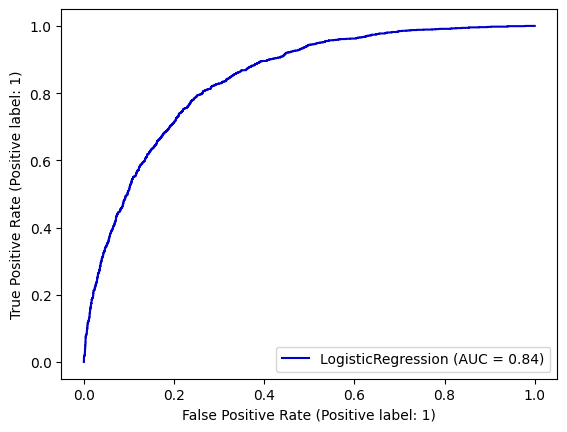

In [32]:
#Acurácia: quantidade de acertos dividivo pelo total da amostra

print(f'Acurácia Treino: %.2f%%' % (accuracy_score(y_train, lr.predict(X_train))*100))
print(f'Acurácia Teste: %.2f%%' % (accuracy_score(y_test, lr.predict(X_test))*100))
print('==============================================================')
print(f'Acurácia Balanceada Treino: %.2f%%' % (balanced_accuracy_score(y_train, lr.predict(X_train))*100))
print('Acurácia Balanceada Teste: %.2f%%' % (balanced_accuracy_score(y_test, lr.predict(X_test))*100))
print('==============================================================')
#Precisão: Dos valores previstos como verdadeiros, quanto o modelo acertou
print(f'Precisão Treino: %.2f%%' % (precision_score(y_train, lr.predict(X_train))*100))
print(f'Precisão Teste: %.2f%%' % (precision_score(y_test, lr.predict(X_test))*100))
print('==============================================================')
#Recall: Porcentagem de positivos previstos corretamente em relação a todos os positivos da amostra
print(f'Recall Treino: %.2f%%' % (recall_score(y_train, lr.predict(X_train))*100))
print(f'Recall Teste: %.2f%%' % (recall_score(y_test, lr.predict(X_test))*100))
print('==============================================================')
#união de recall e precisão
print(f'f1-score Treino: %.2f%%' %(f1_score(y_train, lr.predict(X_train))*100))
print(f'f1-score Teste: %.2f%%' % (f1_score(y_test, lr.predict(X_test))*100))
print('==============================================================')
print(f'ROCAUC Treino: %.2f%%' % (roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])*100))
print(f'ROCAUC Teste: %.2f%%' % (roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])*100))
print('==============================================================')
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()

#Random Forest Classifier

In [33]:
rf = RandomForestClassifier()

In [34]:
rf.fit(X_train, y_train)

<ipython-input-34-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier()

In [37]:
X_test.assign(churn=y_test).assign(label = rf.predict(X_test))


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,churn,label
5839,0.0,1.000000,0.852736,0.865324,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
2098,1.0,0.140845,0.516915,0.094150,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
3762,0.0,0.760563,0.592040,0.490145,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0
1819,0.0,1.000000,0.020398,0.159514,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
60,0.0,0.647887,0.818408,0.540999,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,1.0,0.690141,0.900498,0.624637,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
5729,0.0,0.000000,0.023383,0.000208,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1
4744,0.0,0.309859,0.021891,0.053346,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0
4890,0.0,0.028169,0.069652,0.004627,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1


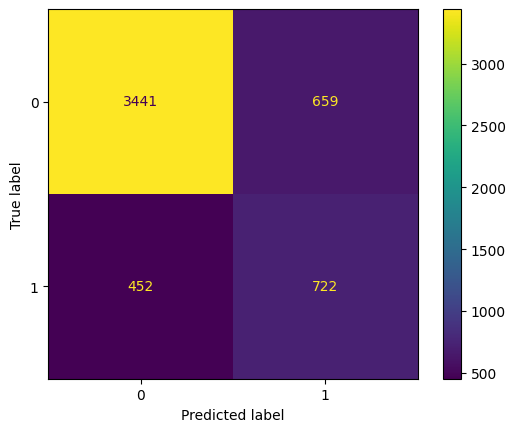

In [38]:

cm = confusion_matrix(rf.predict(X_test), y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm )
disp.plot()

Acurácia Treino: 99.94%
Acurácia Teste: 78.93%
Acurácia Balanceada Treino: 99.96%
Acurácia Balanceada Teste: 70.34%
Precisão Treino: 99.80%
Precisão Teste: 61.50%
Recall Treino: 100.00%
Recall Teste: 52.28%
f1-score Treino: 99.90%
f1-score Teste: 56.52%
ROCAUC Treino: 100.00%
ROCAUC Teste: 82.18%


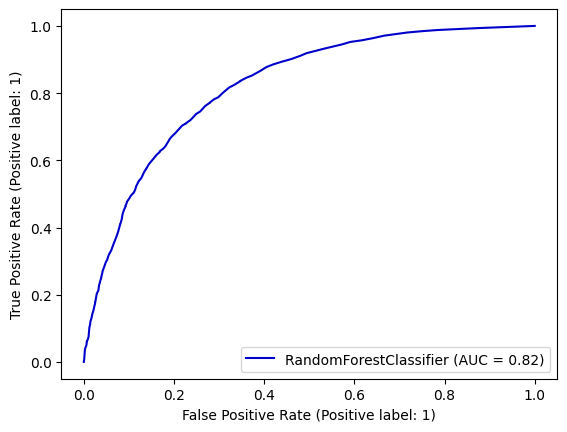

In [39]:
#Acurácia: quantidade de acertos dividivo pelo total da amostra

print(f'Acurácia Treino: %.2f%%' % (accuracy_score(y_train, rf.predict(X_train))*100))
print(f'Acurácia Teste: %.2f%%' % (accuracy_score(y_test, rf.predict(X_test))*100))
print('==============================================================')
print(f'Acurácia Balanceada Treino: %.2f%%' % (balanced_accuracy_score(y_train, rf.predict(X_train))*100))
print('Acurácia Balanceada Teste: %.2f%%' % (balanced_accuracy_score(y_test, rf.predict(X_test))*100))
print('==============================================================')
#Precisão: Dos valores previstos como verdadeiros, quanto o modelo acertou
print(f'Precisão Treino: %.2f%%' % (precision_score(y_train, rf.predict(X_train))*100))
print(f'Precisão Teste: %.2f%%' % (precision_score(y_test, rf.predict(X_test))*100))
print('==============================================================')
#Recall: Porcentagem de positivos previstos corretamente em relação a todos os positivos da amostra
print(f'Recall Treino: %.2f%%' % (recall_score(y_train, rf.predict(X_train))*100))
print(f'Recall Teste: %.2f%%' % (recall_score(y_test, rf.predict(X_test))*100))
print('==============================================================')
#união de recall e precisão
print(f'f1-score Treino: %.2f%%' %(f1_score(y_train, rf.predict(X_train))*100))
print(f'f1-score Teste: %.2f%%' % (f1_score(y_test, rf.predict(X_test))*100))
print('==============================================================')
print(f'ROCAUC Treino: %.2f%%' % (roc_auc_score(y_train, rf.predict_proba(X_train)[:,-1])*100))
print(f'ROCAUC Teste: %.2f%%' % (roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])*100))
print('==============================================================')
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

#Hiperparametros

In [47]:
#Acurácia com grande diferença entre treino e teste. Utilizar grid search para melhorar hiperparametros
parameters = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'n_estimators': [100,300,500]
}

grid_search = GridSearchCV(estimator=rf, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [48]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [45]:
rf_tunned = RandomForestClassifier(
    bootstrap= True,
  ccp_alpha= 0.0,
  class_weight= None,
  criterion='gini',
  max_depth= 10,
  max_features= 'sqrt',
  max_leaf_nodes= None,
  max_samples= None,
  min_impurity_decrease= 0.0,
  min_samples_leaf= 1,
  min_samples_split= 2,
  min_weight_fraction_leaf= 0.0,
  n_estimators= 300,
  n_jobs= None,
  oob_score= False,
  random_state= None,
  verbose= 0,
  warm_start= False
)

In [49]:
rf_tunned.fit(X_train, y_train)

<ipython-input-49-23d38da6abb7>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_tunned.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=300)

In [50]:
rf_tunned.predict(X_test)

array([0, 1, 0, ..., 0, 1, 1])

In [52]:
X_test.assign(churn=y_test).assign(label=rf_tunned.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,churn,label
5839,0.0,1.000000,0.852736,0.865324,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
2098,1.0,0.140845,0.516915,0.094150,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
3762,0.0,0.760563,0.592040,0.490145,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0
1819,0.0,1.000000,0.020398,0.159514,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
60,0.0,0.647887,0.818408,0.540999,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,1.0,0.690141,0.900498,0.624637,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
5729,0.0,0.000000,0.023383,0.000208,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1
4744,0.0,0.309859,0.021891,0.053346,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0
4890,0.0,0.028169,0.069652,0.004627,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1


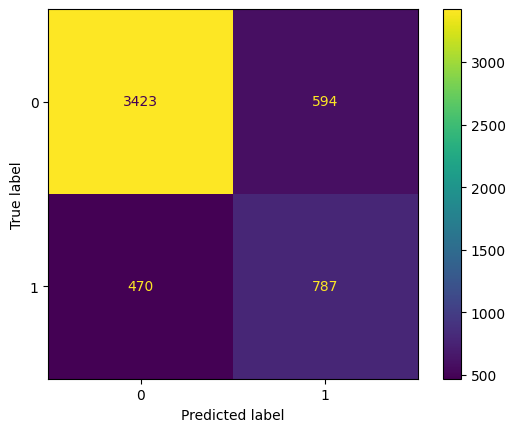

In [53]:
cm = confusion_matrix(rf_tunned.predict(X_test), y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm )
disp.plot()

Acurácia Treino: 95.45%
Acurácia Teste: 79.83%
Acurácia Balanceada Treino: 94.14%
Acurácia Balanceada Teste: 72.46%
Precisão Treino: 92.32%
Precisão Teste: 62.61%
Recall Treino: 91.19%
Recall Teste: 56.99%
f1-score Treino: 91.75%
f1-score Teste: 59.67%
ROCAUC Treino: 98.93%
ROCAUC Teste: 83.70%


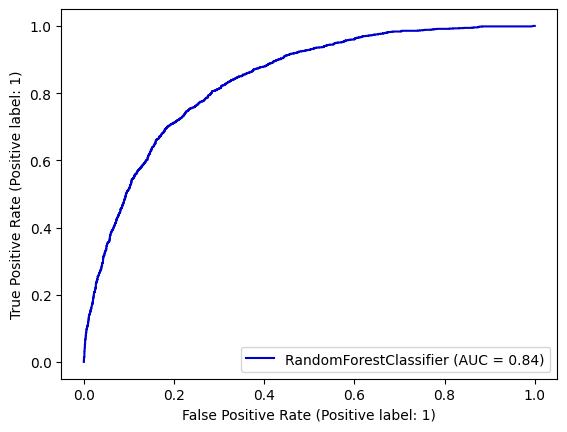

In [51]:
#Acurácia: quantidade de acertos dividivo pelo total da amostra

print(f'Acurácia Treino: %.2f%%' % (accuracy_score(y_train, rf_tunned.predict(X_train))*100))
print(f'Acurácia Teste: %.2f%%' % (accuracy_score(y_test, rf_tunned.predict(X_test))*100))
print('==============================================================')
print(f'Acurácia Balanceada Treino: %.2f%%' % (balanced_accuracy_score(y_train, rf_tunned.predict(X_train))*100))
print('Acurácia Balanceada Teste: %.2f%%' % (balanced_accuracy_score(y_test, rf_tunned.predict(X_test))*100))
print('==============================================================')
#Precisão: Dos valores previstos como verdadeiros, quanto o modelo acertou
print(f'Precisão Treino: %.2f%%' % (precision_score(y_train, rf_tunned.predict(X_train))*100))
print(f'Precisão Teste: %.2f%%' % (precision_score(y_test, rf_tunned.predict(X_test))*100))
print('==============================================================')
#Recall: Porcentagem de positivos previstos corretamente em relação a todos os positivos da amostra
print(f'Recall Treino: %.2f%%' % (recall_score(y_train, rf_tunned.predict(X_train))*100))
print(f'Recall Teste: %.2f%%' % (recall_score(y_test, rf_tunned.predict(X_test))*100))
print('==============================================================')
#união de recall e precisão
print(f'f1-score Treino: %.2f%%' %(f1_score(y_train, rf_tunned.predict(X_train))*100))
print(f'f1-score Teste: %.2f%%' % (f1_score(y_test, rf_tunned.predict(X_test))*100))
print('==============================================================')
print(f'ROCAUC Treino: %.2f%%' % (roc_auc_score(y_train, rf_tunned.predict_proba(X_train)[:,-1])*100))
print(f'ROCAUC Teste: %.2f%%' % (roc_auc_score(y_test, rf_tunned.predict_proba(X_test)[:,1])*100))
print('==============================================================')
RocCurveDisplay.from_estimator(rf_tunned, X_test, y_test)
plt.show()